In [ ]:
!pip install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**GAUSSIAN PROCESS WITH GAUSSIAN KERNELL**

In [ ]:

import matplotlib.pyplot as plt
import torch
import numpy as np


import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from pyro.infer.mcmc import MCMC, NUTS
from pyro.infer import predictive
import pyro
import arviz


import pyro.distributions as pdist
import torch.distributions as tdist

DATA

In [ ]:
# Data
def f(x):
    return torch.sin(20 * x) + (2 * torch.cos(14 * x)) - (2 * torch.sin(6*x))
X = torch.tensor([-1,-1/2, 0, 1/2, 1])

y = f(X)
# y_mean = torch.mean(y)
# y_std  = torch.std(y)
# y = (y - y_mean)/y_std


**Gaussian Process MCMC to determine kernel parameters (posterior)**

In [ ]:
# Defining kernel with priors on the parameters
kernel = gp.kernels.RBF(input_dim=1)
kernel.lengthscale = pyro.nn.PyroSample(pdist.LogNormal(torch.tensor(-1.), torch.tensor(1.)))
kernel.variance  = pyro.nn.PyroSample(pdist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))

def my_MCMC(X, y, kernel, num_samples = 500, chains=4, noise = torch.tensor(1e-4)):
    gpr = gp.models.GPRegression(X, y, kernel, noise=noise)
    
    #MCMC to determine posterior over parameters
    nuts_kernel = NUTS(gpr.model, jit_compile=True)
    mcmc = MCMC(nuts_kernel,  num_samples=num_samples, num_chains=chains, warmup_steps=200)
    mcmc.run()

    #Accessing the samples
    ls_name = "kernel.lengthscale"
    var_name = "kernel.variance"
    posterior_ls = mcmc.get_samples()[ls_name]
    posterior_var = mcmc.get_samples()[var_name]
    return mcmc, posterior_ls, posterior_var

mcmc, posterior_ls, posterior_var = my_MCMC(X, y, kernel)


/usr/local/lib/python3.8/dist-packages/pyro/infer/mcmc/api.py:497: UserWarning: num_chains=4 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(
Warmup:   0%|          | 0/700 [00:00, ?it/s]/usr/local/lib/python3.8/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Warmup:   0%|          | 0/700 [00:00, ?it/s]/usr/local/lib/python3.8/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) !

Log-log Raw Data

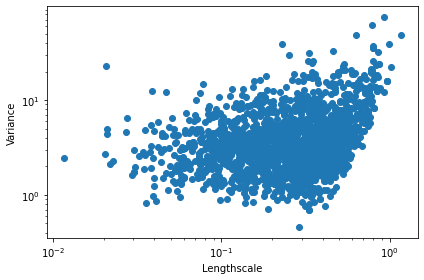

In [ ]:
fig, axis = plt.subplots()
axis.scatter(posterior_ls, posterior_var)
axis.set_xlabel("Lengthscale")
axis.set_ylabel("Variance")
axis.set_xscale("log")
axis.set_yscale("log")
fig.tight_layout()
fig.savefig("log-log_samples.png", dpi=300)

**ARVIZ**

/usr/local/lib/python3.8/dist-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


                     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.lengthscale  0.306  0.181   0.020    0.626      0.008    0.006   
kernel.variance     4.646  4.872   0.766   12.048      0.235    0.167   

                    ess_bulk  ess_tail  r_hat  
kernel.lengthscale     466.0     589.0   1.01  
kernel.variance        659.0     445.0   1.01  


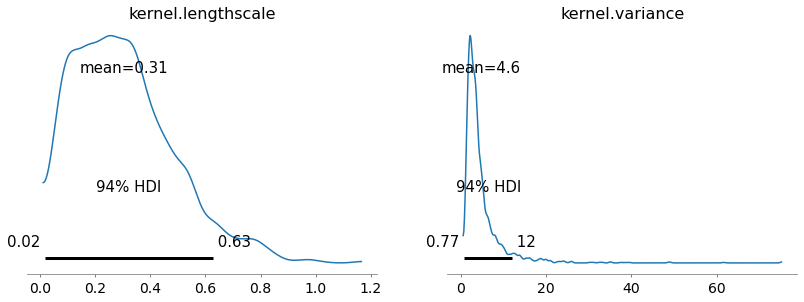

In [ ]:
data = arviz.from_pyro(mcmc)
summary = arviz.summary(data) # ESS, r-hat
print(summary)
arviz.plot_posterior(data) # Density plot
plt.show()

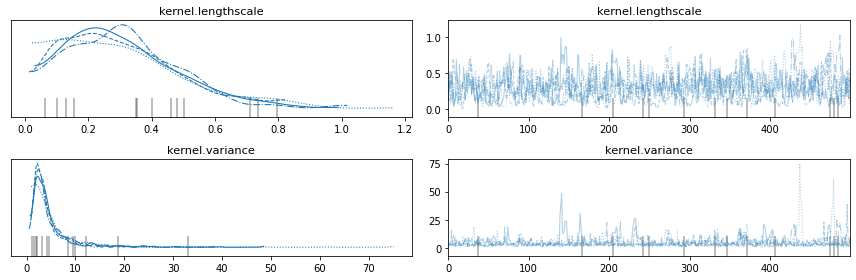

In [ ]:
arviz.plot_trace(data)
_ = plt.tight_layout()
plt.savefig("arviz_trace.png", dpi=300)

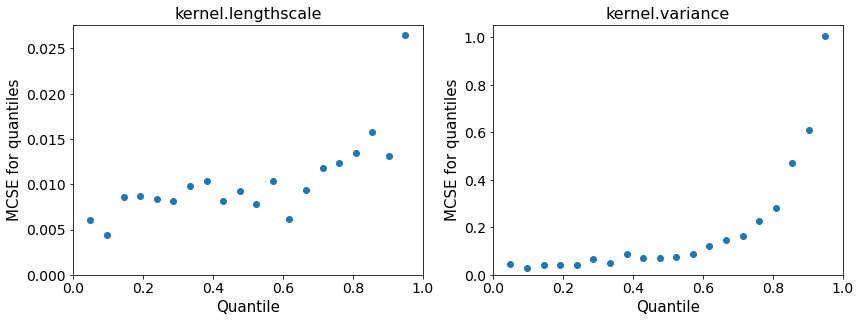

In [ ]:
arviz.plot_mcse(data)
plt.savefig("arviz_mcse.png", dpi=300)

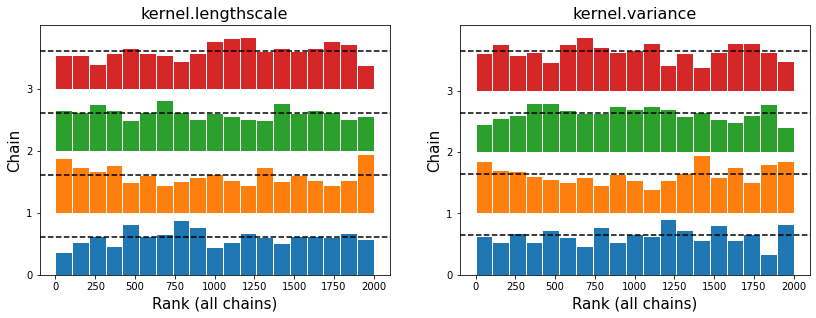

In [ ]:
arviz.plot_rank(data)
plt.savefig("arviz_rank.png", dpi=300)

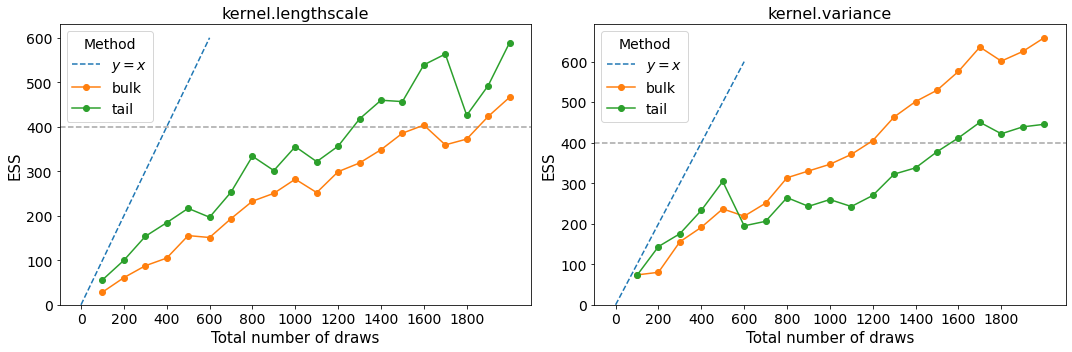

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
seq = np.arange(0, 700, step=200)
ticks = np.arange(0, 2000, step=200)
ax[0].plot(seq, seq, '--', label=r"$y=x$")
ax[0].set_xticks(ticks)
ax[1].plot(seq, seq, '--', label=r"$y=x$")
ax[1].set_xticks(ticks)
arviz.plot_ess(data, kind='evolution', ax=ax)
fig.tight_layout()
fig.savefig("arviz_ess_evolution.png", dpi=300)

**Predictive posterior**

$$\int P(\theta |Data) P(f^{*}|X,X^{*},y,\theta) d\theta \approx (1/N) \sum_{\theta \in \Theta} P(f^{*}|X,X^{*},y,\theta) $$

In [ ]:
y = f(X)

X_n = 101
total_samples = posterior_ls.shape[0] #number of samples for all chains
z = torch.linspace(-1,1,X_n) # 200 evenly spaced values between -1 and 1
#Initializing vector and matrix for means and covariances 

means = torch.zeros(X_n)
cov_matrix = torch.zeros(X_n)#torch.zeros(X_n*X_n).view(X_n,X_n)

#iterating through all posterior samples
for i in range(total_samples): 
    pyro.clear_param_store()
    lengthscale, variance = posterior_ls[i], posterior_var[i]
    kernel = gp.kernels.RBF(input_dim=1, variance=variance, 
                          lengthscale=lengthscale)
    gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1e-4))
    m, covvar = gpr.forward(z, full_cov=False, noiseless=False)
    means += m 
    cov_matrix += covvar

means /= total_samples
cov_matrix /= total_samples

**Plotting predictive posterior**

[0.01417908 0.27009034 0.47546476 0.6378894  0.77024895 0.8786904
 0.9674224  1.0393922  1.0967119  1.1408861  1.1729679  1.1936648
 1.2034237  1.2024791  1.1908845  1.1685029  1.1349823  1.089703
 1.0316819  0.9594702  0.8709904  0.7633014  0.63217515 0.47140875
 0.26799908 0.01420042 0.2679581  0.47123304 0.6317446  0.76248056
 0.869634   0.9574343  1.0288266  1.085906   1.1301476  1.162564
 1.183819   1.1943108  1.1942286  1.1835748  1.1621739  1.1296355
 1.085304   1.028172   0.9567692  0.86900127 0.7619203  0.63129395
 0.47092125 0.26780286 0.01417951 0.26780233 0.47092095 0.63129365
 0.76192003 0.869001   0.9567692  1.028172   1.085304   1.1296355
 1.162174   1.1835748  1.1942289  1.1943109  1.1838192  1.1625638
 1.1301476  1.0859058  1.0288267  0.95743406 0.86963356 0.7624802
 0.6317447  0.47123262 0.26795805 0.01417903 0.26799905 0.47140813
 0.63217515 0.76330096 0.87099046 0.95947015 1.031682   1.089703
 1.1349823  1.1685029  1.1908845  1.202479   1.2034236  1.1936649
 1.17296

<ipython-input-12-02ee4c05fc2e>:19: MatplotlibDeprecationWarning: Unrecognized location 'bottom left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(loc='bottom left', prop={'size': 7})


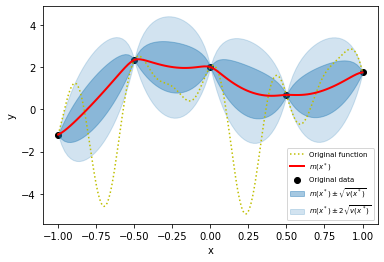

In [ ]:
x_ax = z.detach().numpy() # x-axis
y_ax = means.detach().numpy() #means of the averaged multivariate gaussian for the posterior predictive
#sd = (cov_matrix.diag()).sqrt().detach().numpy() #standard deviations of means
sd = cov_matrix.sqrt().detach().numpy()
print(sd, sd.shape)
newx = torch.linspace(-1,1,200)
newy = f(newx)
print(means.shape, z.shape)
plt.plot(newx, newy, 'y:', label="Original function")
# plot the mean
plt.plot(x_ax, y_ax, "r", lw=2, label=r"$m(x^*)$")  
plt.scatter(X,y, c='k', label="Original data")
 
# plot the one and two-sigmas uncertainty about the mean
plt.fill_between(x_ax, (y_ax - 1.0 * sd),(y_ax + 1.0 * sd), color="C0", 
                  alpha=0.4, label=r"$m(x^*) \pm \sqrt{v(x^*)}$")
plt.fill_between(x_ax, (y_ax - 2.0 * sd),(y_ax + 2.0 * sd), color="C0", 
                  alpha=0.2, label=r"$m(x^*) \pm 2\sqrt{v(x^*)}$")
plt.legend(loc='bottom left', prop={'size': 7})
plt.ylabel("y")
plt.xlabel("x")

plt.savefig("simple_gp.png", dpi=300)

Plotting function for next section:

In [ ]:
def plot_bayes_optim(val, Xnew, sample, n_X, n_posterior_samples):
    #number of samples for all chains
    # 200 evenly spaced values between -1 and 1

    #Initializing vector and matrix for means and covariances 
    means2 = torch.zeros(n_X)
    cov_matrix2 = torch.zeros(n_X*n_X).view(n_X,n_X)

        #iterating through all posterior samples
    for i in range(n_posterior_samples): 
        pyro.clear_param_store()
        lengthscale, variance = posterior_ls[i], posterior_var[i]
        kernel3 = gp.kernels.RBF(input_dim=1, variance=variance, 
                              lengthscale=lengthscale)
        gpr3 = gp.models.GPRegression(X, y, kernel3,noise=torch.tensor(1e-4))
        m2, covvar2 = gpr3.forward(Xnew, full_cov=True, noiseless=False)
        means2 += m2
        cov_matrix2 += covvar2
    means2 /= n_posterior_samples
    cov_matrix2 /= n_posterior_samples
    x_ax = z.detach().numpy() # x-axis
    y_ax = means2.detach().numpy() #means of the averaged multivariate gaussian for the posterior predictive
    sd = cov_matrix2.diag().sqrt().detach().numpy() #standard deviations of means
    newx = torch.linspace(-1,1,101)
    newy = f(newx)
    plt.plot(newx, newy, 'y--', label = "Objective function")
    #plt.scatter(X,y,c='y')
    # plot the mean
    plt.plot(x_ax, y_ax, "r", lw=2, label=r"$m(x^*)$")  
    # plot the one and two-sigmas uncertainty about the mean
    # plot the one and two-sigmas uncertainty about the mean
    plt.fill_between(x_ax, (y_ax - 1.0 * sd),(y_ax + 1.0 * sd), color="C0", 
                      alpha=0.4, label=r"$m(x^*) \pm \sqrt{v(x^*)}$")
    plt.fill_between(x_ax, (y_ax - 2.0 * sd),(y_ax + 2.0 * sd), color="C0", 
                      alpha=0.2, label=r"$m(x^*) \pm 2\sqrt{v(x^*)}$")
    plt.title("Bayesian Optimization RBF kernel (iteration = " + str(val+1) + ")")
    #plt.plot(Xnew, sample.view(-1))
    plt.scatter(X[-1], y[-1], label="Latest added point")
    plt.legend(loc='upper left', prop={'size': 7})
    plt.show() 
    return None

**Bayesian optimization algorithm**

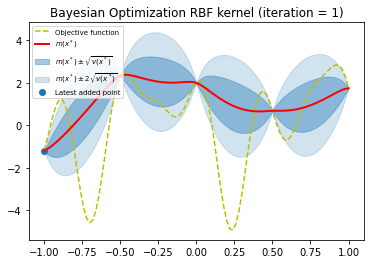

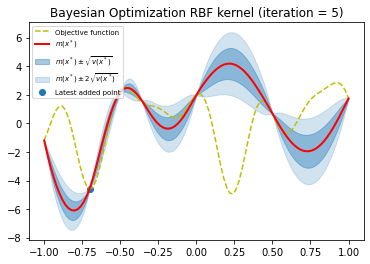

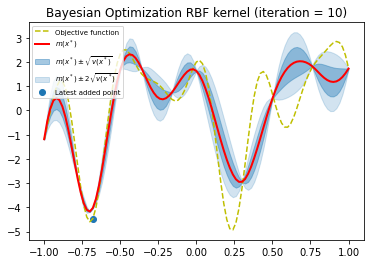

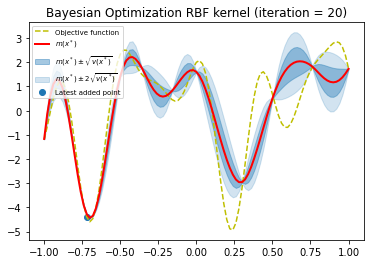

Minimum point: -0.70000005 -4.594611


<Figure size 432x288 with 0 Axes>

In [ ]:
X = torch.tensor([-1,-1/2, 0, 1/2, 1])
y = f(X)

total_its = 20
n_X = 101
Xnew = torch.linspace(-1,1,n_X)
num_samples = 500

for i in range(total_its):
    pyro.clear_param_store()
    
    # sampling a lengthscale and variance from the posterior
    I = torch.randint_like(torch.tensor(0), torch.tensor(num_samples))
    lenscale, varians = posterior_ls[I], posterior_var[I]

    #defining kernel to have sampled variacne and legthscale
    kernel =  gp.kernels.RBF(input_dim=1, variance=varians, lengthscale=lenscale)
    gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1e-4))

    # mean and covariance from the gaussian process
    m, covvar = gpr.forward(z, full_cov=True, noiseless=False)

    # sampling accordingly
    sample = dist.MultivariateNormal(m, covariance_matrix=covvar).sample(sample_shape=(1,))
    
    #adding minimum f* value and correspoding x value to y and X respectively
    min_val, min_idx = sample.min(dim=1)
    x_to_be_added, y_to_be_added = Xnew[min_idx], f(Xnew[min_idx])
    X = torch.cat([X, x_to_be_added], 0)
    y = torch.cat([y, y_to_be_added], 0)

    if i in [0,4,9,19]:
        ##PLOTTING
        plot_bayes_optim(i, Xnew=Xnew, sample=sample, n_X=n_X, n_posterior_samples=num_samples)
        plt.savefig(f"BO_i{i}.png", dpi=300)
    
    
y_min, y_min_idx = y.min(dim=0)
print("Minimum point:", X[y_min_idx].numpy(), y_min.numpy())